In [11]:
!pip install pandas matplotlib seaborn numpy notebook replicate langchain_community

In [12]:
# A. SET UP Libraries

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import notebook
from langchain_community.llms import Replicate
import time
from google.colab import drive
from google.colab import userdata
import os

In [13]:
# Mounting Google drive
try:
  drive.mount('/content/drive')
  print("Google Drive berhasil terhubung")
except Exception as e:
  print(f"Gagal Menghubungkan google drive: {e}")

# API_Token Configuration
# Masukkan api_token dari google colab
api_token = userdata.get("api_token")
# Masukkan tabel ke environment variable
os.environ["REPLICATE_API_TOKEN"] = api_token



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive berhasil terhubung


Dataset Berhasil Dimuat...


   Student_ID  Age  Gender Academic_Level     Country  Avg_Daily_Usage_Hours  \
0           1   19  Female  Undergraduate  Bangladesh                    5.2   
1           2   22    Male       Graduate       India                    2.1   
2           3   20  Female  Undergraduate         USA                    6.0   
3           4   18    Male    High School          UK                    3.0   
4           5   21    Male       Graduate      Canada                    4.5   

  Most_Used_Platform Affects_Academic_Performance  Sleep_Hours_Per_Night  \
0          Instagram                          Yes                    6.5   
1            Twitter                           No                    7.5   
2             TikTok                          Yes                    5.0   
3            YouTube                           No                    7.0   
4           Facebook                          Yes                    6.0   

   Mental_Health_Score Relationsh

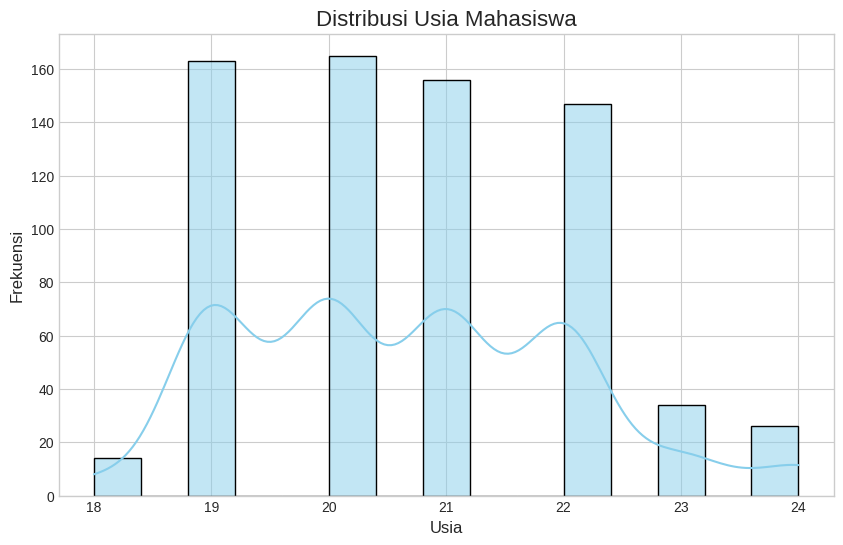


Kolom untuk waktu ditemukan: 'Avg_Daily_Usage_Hours'


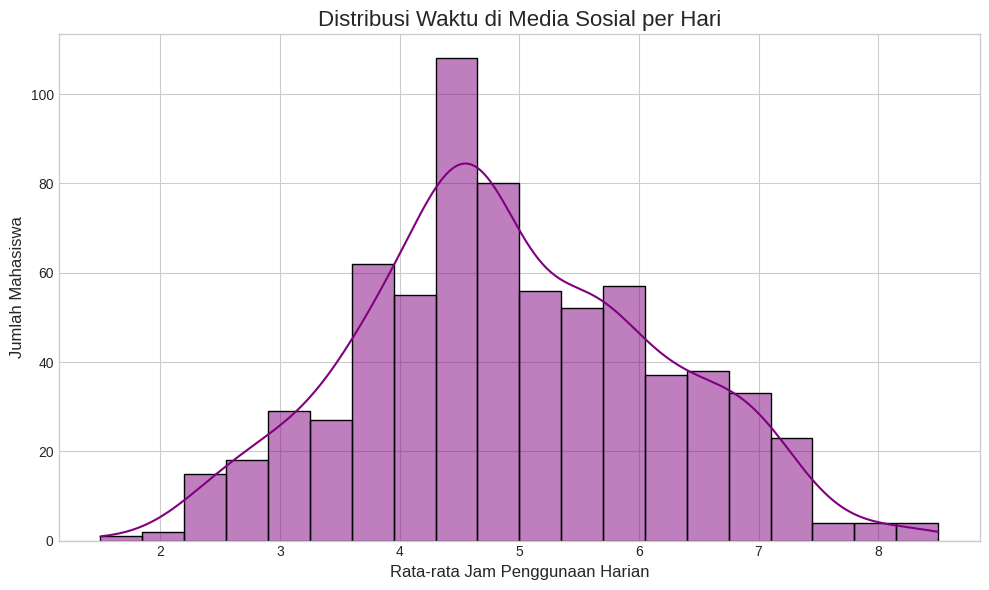

In [14]:
# B. EDA
# file_path yang digunakan (usahakan pakai drive dekstop)
file_path = "/content/drive/My Drive/Students_Social_Media_Addiction.csv"

try:
  df = pd.read_csv(file_path)
  print("Dataset Berhasil Dimuat...")
except FileNotFoundError:
  print(f"File tidak ditemukan di path: {file_path}. Pastikan path sudah benar")
  df = None # Hentikan Eksekusi jika file tidak ada

if df is not None:
  # Tampilkan 5 baris data pertama
  print("\n")
  print(df.head())
  # Tampilkan info dasar dataframe
  print("\n")
  print(df.info())
  # Analisis Deskriptif untuk kolom numerik
  print("\n")
  print(df.describe())
  # Visualisasi Data Awal
  plt.style.use('seaborn-v0_8-whitegrid')

  # 1. Distribusi Usia
  plt.figure(figsize=(10, 6))
  sns.histplot(df['Age'], bins=15, kde = True, color='skyblue')
  plt.title('Distribusi Usia Mahasiswa', fontsize = 16)
  plt.xlabel('Usia', fontsize=12)
  plt.ylabel('Frekuensi', fontsize=12)
  plt.show()

  # 2. Waktu Rata-rata di Media Sosial
  # --- PERBAIKAN UNTUK MENGHINDARI KEYERROR DAN MERAPIKAN PLOT ---
  # Secara dinamis mencari nama kolom yang benar untuk 'waktu yang dihabiskan'
  time_spent_col = None
  for col in df.columns:
      # Menggunakan 'time you spend' atau 'usage_hours' sebagai kata kunci
      if 'time you spend' in col.lower() or 'usage_hours' in col.lower():
          time_spent_col = col
          print(f"\nKolom untuk waktu ditemukan: '{time_spent_col}'")
          break

  if time_spent_col:
      # Karena kolom 'Avg_Daily_Usage_Hours' adalah numerik, kita gunakan histplot
      # bukan countplot, untuk hasil yang lebih tepat.
      plt.figure(figsize=(10, 6))
      sns.histplot(df[time_spent_col], bins=20, kde=True, color='purple')

      plt.title('Distribusi Waktu di Media Sosial per Hari', fontsize=16)
      plt.xlabel('Rata-rata Jam Penggunaan Harian', fontsize=12)
      plt.ylabel('Jumlah Mahasiswa', fontsize=12)
      plt.tight_layout()
      plt.show()

  else:
      print("\nPERINGATAN: Tidak dapat menemukan kolom 'time you spend' atau 'usage_hours'. Visualisasi untuk waktu dilewati.")








In [15]:
# Langkah 3: Klasifikasi Tingkat Kecanduan Memakai LLM


llm = Replicate(
    model="ibm-granite/granite-3.3-8b-instruct",
    model_kwargs={"max_new_tokens": 10, "temperature": 0.3}
)

def classify_addiction_level(row):
    """
    Fungsi untuk mengklasifikasikan tingkat kecanduan menggunakan model Langchain.
    """
    prompt_template = f"""
    Anda adalah seorang psikolog digital. Berdasarkan data survei mahasiswa berikut, klasifikasikan tingkat potensi kecanduan media sosialnya ke dalam salah satu dari tiga kategori: 'Rendah', 'Sedang', atau 'Tinggi'.

    Data Mahasiswa:
    - Usia: {row['Age']}
    - Gender: {row['Gender']}
    - Waktu di Medsos per hari (jam): {row['Avg_Daily_Usage_Hours']}
    - Jam Tidur per Malam: {row['Sleep_Hours_Per_Night']}
    - Skor Kesehatan Mental (1-10, 10=baik): {row['Mental_Health_Score']}
    - Skor Kecanduan yang dilaporkan (1-10, 10=kecanduan): {row['Addicted_Score']}

    Berdasarkan kombinasi data di atas, berikan HANYA SATU KATA sebagai output klasifikasi: 'Rendah', 'Sedang', atau 'Tinggi'.
    """

    try:
        # Memanggil model dengan llm.invoke()
        output = llm.invoke(prompt_template)
        # --- PERBAIKAN: Menghapus print() yang tidak perlu ---
        classification = output.strip().replace("'", "").replace('"', '').replace(".", "")

        if classification not in ['Rendah', 'Sedang', 'Tinggi']:
            # Jika output tidak sesuai format, coba ambil kata pertama secara diam-diam
            first_word = classification.split()[0].replace("*","")
            if first_word in ['Rendah', 'Sedang', 'Tinggi']:
                return first_word
            return 'Tidak Terklasifikasi' # Tandai sebagai tidak terklasifikasi jika masih gagal
        return classification
    except Exception as e:
        # Hanya print jika terjadi error koneksi atau API
        print(f"Error saat memanggil API Replicate: {e}")
        return "Error"

if df is not None:
    print("\n--- Memulai Proses Klasifikasi dengan  (Langchain) ---")

    print("Menjalankan klasifikasi pada seluruh dataset... Ini akan memakan waktu beberapa menit. Harap tunggu.")
    df_classified = df.copy()
    df_classified['Tingkat_Kecanduan'] = df_classified.apply(classify_addiction_level, axis=1)
    print("Klasifikasi selesai.")

    # Simpan hasil ke file CSV baru
    df_classified.to_csv('/content/drive/My Drive/hasil_klasifikasi_kecanduan_langchain.csv', index=False)
    print("Hasil klasifikasi telah disimpan ke Google Drive.")

    print("\n--- Contoh Hasil Klasifikasi ---")
    print(df_classified[['Age', 'Gender', 'Avg_Daily_Usage_Hours', 'Tingkat_Kecanduan']].head(10))



--- Memulai Proses Klasifikasi dengan  (Langchain) ---
Menjalankan klasifikasi pada seluruh dataset... Ini akan memakan waktu beberapa menit. Harap tunggu.
Klasifikasi selesai.
Hasil klasifikasi telah disimpan ke Google Drive.

--- Contoh Hasil Klasifikasi ---
   Age  Gender  Avg_Daily_Usage_Hours Tingkat_Kecanduan
0   19  Female                    5.2            Tinggi
1   22    Male                    2.1            Rendah
2   20  Female                    6.0            Tinggi
3   18    Male                    3.0            Sedang
4   21    Male                    4.5            Tinggi
5   19  Female                    7.2            Tinggi
6   23    Male                    1.5            Rendah
7   20  Female                    5.8            Tinggi
8   18    Male                    4.0            Sedang
9   21  Female                    3.3            Sedang



--- Menganalisis Hasil Klasifikasi yang Sebenarnya ---

--- Distribusi Tingkat Kecanduan ---
Tingkat_Kecanduan
Tinggi    398
Sedang    275
Rendah     32
Name: count, dtype: int64


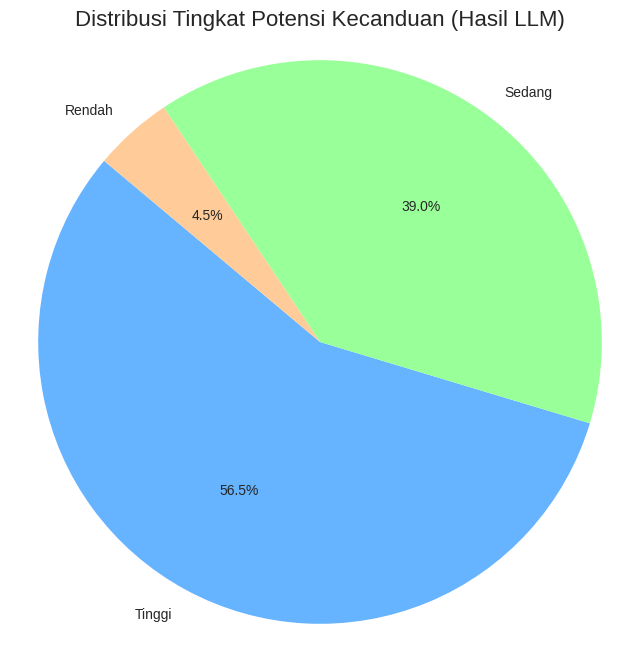


--- Ringkasan Profil untuk Setiap Kelompok ---

--- Profil Kelompok: Rendah ---
Kelompok mahasiswa dengan tingkat kecanduan 'Rendah' terkait dengan penggunaan aplikasi sosial dan tidur memiliki profil yang baik. Mereka menghabiskan rata-rata 2.8 jam per hari di platform sosial, dengan LINE merupakan pilihan terpopuler. Meskipun mereka menghabiskan waktu di media sosial, mereka tetap mendapatkan 8.2 jam tidur per malam, menunjukkan pengelolaan waktu yang baik. Tingkat performa akademik mereka tidak terganggu, dengan persentase nol, menunjukkan konsistensi dalam kinerja akademik. Kelompok ini mungkin memiliki strategi yang efektif dalam mengatasi kecanduan teknologi tanpa mengancam aspek-aspek penting lain, seperti kesehatan mental dan kinerja akademik.

--- Profil Kelompok: Sedang ---
Kelompok mahasiswa dengan keluasan kecanduan terclassifikasikan sebagai 'Sedang' memiliki beberapa profil tingkat kecanduan yang menarik untuk dianalisis. Mereka menghabiskan rata-rata 4.1 jam perhari di 

In [16]:

# ------------------------------------------------------------------------------
# LANGKAH 4: ANALISIS & SUMMARIZATION HASIL KLASIFIKASI
# ------------------------------------------------------------------------------

if 'df_classified' in locals() and not df_classified.empty:
    print("\n--- Menganalisis Hasil Klasifikasi yang Sebenarnya ---")

    # 1. Analisis Distribusi Hasil Klasifikasi
    print("\n--- Distribusi Tingkat Kecanduan ---")
    addiction_counts = df_classified['Tingkat_Kecanduan'].value_counts()
    print(addiction_counts)

    plt.figure(figsize=(8, 8))
    valid_counts = addiction_counts[addiction_counts.index.isin(['Rendah', 'Sedang', 'Tinggi', 'Tidak Terklasifikasi', 'Error'])]
    plt.pie(valid_counts, labels=valid_counts.index, autopct='%1.1f%%', startangle=140, colors=['#66b3ff','#99ff99','#ffcc99', '#ff6666', '#cccccc'])
    plt.title('Distribusi Tingkat Potensi Kecanduan (Hasil LLM)', fontsize=16)
    plt.axis('equal')
    plt.show()

    # 2. Summarization Profil
    llm_summarizer = Replicate(
        model="ibm-granite/granite-3.3-8b-instruct",
        model_kwargs={"max_new_tokens": 150} # Token lebih banyak untuk ringkasan
    )

    def summarize_group_profile(group_df, group_name):
        if group_df.empty:
            return f"Tidak ada data untuk kelompok '{group_name}'."

        avg_time_spent = group_df['Avg_Daily_Usage_Hours'].mean()
        most_common_platform = group_df['Most_Used_Platform'].mode()[0]
        avg_sleep = group_df['Sleep_Hours_Per_Night'].mean()
        academic_impact_pct = (group_df['Affects_Academic_Performance'] == 'Yes').mean() * 100

        prompt_template = f"""
        Anda adalah seorang analis data. Berdasarkan statistik dari kelompok mahasiswa yang diklasifikasikan memiliki tingkat kecanduan '{group_name}', buatlah ringkasan profil dalam satu paragraf (3-4 kalimat).

        Statistik Kelompok '{group_name}':
        - Rata-rata waktu di medsos: {avg_time_spent:.1f} jam/hari.
        - Platform paling populer: {most_common_platform}.
        - Rata-rata jam tidur: {avg_sleep:.1f} jam/malam.
        - Persentase performa akademik terganggu: {academic_impact_pct:.0f}%.

        Jelaskan profil khas kelompok ini dalam narasi yang mudah dipahami.
        """
        try:
            summary = llm_summarizer.invoke(prompt_template)
            return summary.strip()
        except Exception as e:
            return f"Gagal membuat ringkasan: {e}"

    print("\n--- Ringkasan Profil untuk Setiap Kelompok ---")
    for level in ['Rendah', 'Sedang', 'Tinggi']:
        print(f"\n--- Profil Kelompok: {level} ---")

        group_df = df_classified[df_classified['Tingkat_Kecanduan'] == level]

        if not group_df.empty:
            summary = summarize_group_profile(group_df, level)
            print(summary)
        else:
            print(f"Tidak ada mahasiswa yang diklasifikasikan sebagai '{level}'.")
        time.sleep(1)

else:
    print("\nAnalisis akhir dilewati karena klasifikasi belum dijalankan.")

print("\n--- Analisis Selesai ---")
